In [64]:
pip install -e ../../circe

Obtaining file:///home/rtrimbou/ATACNet/circe
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for circe-py (pyproject.toml) ... one
  Created wheel for circe-py: filename=circe_py-0.3.5-0.editable-cp310-cp310-linux_x86_64.whl size=14983 sha256=f7eefd885b8586aae38bacf4fc94a2d4bd3c6f8c27871e560829ff8fb650e347
  Stored in directory: /tmp/pip-ephem-wheel-cache-l22fk5nv/wheels/06/5a/23/bdd6ba9528cfb814fe87ae531ac60685ff8b049382fd6df5e0
Successfully built circe-py
  Attempting uninstall: circe-py
    Found existing installation: circe-py 0.3.5
    Uninstalling circe-py-0.3.5:
      Successfully uninstalled circe-py-0.3.5
Note: you may need to restart the kernel to use updated packages.


# **Cis co-accessibility network with Circe**

In [3]:
pip install -e ../.

Obtaining file:///home/rtrimbou/ATACNet/circe
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for circe-py (pyproject.toml) ... done
  Created wheel for circe-py: filename=circe_py-0.3.5-0.editable-cp310-cp310-linux_x86_64.whl size=14980 sha256=c3b73719339621a42d86f4e800853841dd74aba12c2454d92dc6eeec9dfdcb4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ad_o605e/wheels/06/5a/23/bdd6ba9528cfb814fe87ae531ac60685ff8b049382fd6df5e0
Successfully built circe-py
  Attempting uninstall: circe-py
    Found existing installation: circe-py 0.3.5
    Uninstalling circe-py-0.3.5:
      Successfully uninstalled circe-py-0.3.5

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import circe as ci
import scanpy as sc
import scipy as sp

In [2]:
pip show circe-py

Name: circe-py
Version: 0.3.5
Summary: Circe: Package for building co-accessibility networks from ATAC-seq data.
Home-page: https://github.com/cantinilab/circe
Author: Remi-Trimbour
Author-email: remi.trimbour@pasteur.fr
License: 
Location: /home/rtrimbou/miniconda3/envs/circe_local/lib/python3.10/site-packages
Editable project location: /home/rtrimbou/ATACNet/circe
Requires: Cython, dask, distributed, joblib, numpy, pandas, rich, scanpy, scikit-learn
Required-by: 
Note: you may need to restart the kernel to use updated packages.


#### Create fake AnnData

This data doesn't contain strong correlation between fake regions, the score will then be low. 

It will still allow us to demonstrate how to use Circe. :)

In [25]:
atac = sc.datasets.blobs(n_centers=8, n_variables=2_000, n_observations=300, random_state=0)
atac.X = np.random.poisson(lam=4, size=atac.X.shape)
cell_names = [f"cell_{i}" for i in range(1, atac.shape[0]+1)]
# number of chr_start_end region names
region_names = [[f"chr{i}_{str(j)}_{str(j+150)}" 
                 for j in range(1, 10000*400+1, 10000)] 
                for i in range(1, 6)]
regions_names = [item for sublist in region_names for item in sublist]
atac.var_names = regions_names
atac.obs_names = cell_names

#### Filter the data

In [26]:
sc.pp.filter_genes(atac, min_cells=1)
sc.pp.filter_cells(atac, min_genes=1)
atac

AnnData object with n_obs × n_vars = 300 × 2000
    obs: 'blobs', 'n_genes'
    var: 'n_cells'

### 1. Add region position in AnnData.obs

Let's first run `add_region_infos` that will <font color=#F98128>**add coordinate annotations**</font> `chr`, `start`, `end` as columns in `atac.var` slot

In [27]:
atac = ci.add_region_infos(atac)

### 2. Compute pseudocells

<font color=#F98128>**Compute metacells**</font> is an interesting step to reduce sparsity in our data, since scATAC-seq data have usually a lot of dropouts.

In [28]:
metacells = ci.metacells.compute_metacells(atac)

Output()

/home/rtrimbou/ATACNet/circe/circe/metacells.py:191: ImplicitModificationWarning: Setting element `.obsm['X_lsi']` of view, initializing view as actual.
  adata.obsm["X_lsi"] = X_lsi


You can also use your own dimensionality reduction space, that would be stored in the atac.obsm slot

In [29]:
atac.obsm["dim"] = atac.X

In [30]:
ci.metacells.compute_metacells(atac, dim_reduction="dim")

Using adata.obsm['dim'] to identify neighboring cells


Output()

AnnData object with n_obs × n_vars = 300 × 2000
    var: 'n_cells', 'chromosome', 'start', 'end'

### 3. Calculate co-accessibility

#### 3.A. Human datasets

We can finally <font color=#F98128>**compute all the cis co-accessibility scores**</font> ! <br>
The default way is to <font color='#50B848'>**indicate your organism**</font> if among the one known by Circe.<br>
The atac network is stored automatically as a sparse matrix in `atac.varp["atac_network"]`

In [31]:
ci.compute_atac_network(
    atac, #metacells,
    organism="human",
    njobs=3,
)
atac.varp["atac_network"]

Output()

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 117128 stored elements and shape (2000, 2000)>

#### 3.B. Other organisms

##### If your organism is **not** <font color=#50B848>"human"</font>, <font color=#50B848>"mouse"</font> or <font color=#50B848>"drosophila"</font>, human default values will be used for:
`s`, `window_size` and `distance_constraint`.
Distance constraint is usually half of the window size.

If you know their values,
you can also specify yourself the following parameters that are organism-specific.

In [32]:
window_size = 100_000
distance_constraint=50_000
s = 0.85
ci.compute_atac_network(
    atac, #metacells,
    window_size=window_size,
    s=s,
    distance_constraint=distance_constraint,
    unit_distance = 1000,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=100
)

Output()

#### 3.C. Use of sparse matrix

1. Circe can also work with `sparse covariance matrix`.<br>

In [33]:
atac.X = sp.sparse.csr_matrix(atac.X)
# atac.X = atac.X.toarray()

2. Connections can also be stored externally from your `AnnData` object using `sliding_graphical_lasso`.

In [34]:
final_score = ci.sliding_graphical_lasso(
    atac,
    n_samples=50,
    n_samples_maxtry=100,
    max_alpha_iteration=500,
    verbose=0
)
atac.varp['atac_network'] = final_score

Output()

/home/rtrimbou/ATACNet/circe/circe/circe.py:935: UserWarning: 
                No organism, nor value passed for the parameters: ['window_size', 'distance_constraint', 's'],
                using default values.
                The default values are defined from human and mouse data,
                you might want to change them if you are working with
                another organisms.

                Default values used:
                {'window_size': 500000, 'distance_constraint': 250000, 's': 0.75}

                You can check how to define them in https://cole-trapnell-lab.github.io/cicero-release/docs_m3/#important-considerations-for-non-human-data.
                
  warnings.warn(


### 4. Extract connections

#### 4.A.Get the whole genome cis-coaccessible network

You can <font color='#F98128'>**extract connections**</font> from the atac.varp slot (sparse matrix), as a `DataFrame object` with `extract_atac_links`.

In [35]:
circe_network = ci.extract_atac_links(atac) #metacells)
circe_network.head(3)

/home/rtrimbou/miniconda3/envs/circe_local/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


,Peak1,Peak2,score
0,chr2_520001_520151,chr2_550001_550151,0.147387
1,chr5_2260001_2260151,chr5_2270001_2270151,0.145649
2,chr1_1110001_1110151,chr1_1120001_1120151,0.139726


#### 4.B. Subset the AnnData object to a given window

If you're interested in a specific genomic region only, you can also <font color='#F98128'>**subset your anndata object**</font> on this specific window

In [36]:
atac.varp["atac_network"]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 118204 stored elements and shape (2000, 2000)>

In [37]:
subset_atac = ci.subset_region(atac, "chr1", 10_000, 200_000).copy()

In [38]:
circe_network_subset = ci.extract_atac_links(subset_atac)
circe_network_subset.head(3)

/home/rtrimbou/miniconda3/envs/circe_local/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


,Peak1,Peak2,score
0,chr1_90001_90151,chr1_130001_130151,0.086369
1,chr1_160001_160151,chr1_170001_170151,0.031320
2,chr1_120001_120151,chr1_180001_180151,0.026739


### 5. Plot co-accessibility scores in a window

You can pass either your `anndata` object or your freshly extracted `dataframe` into `plot_connections` to <font color=#F98128>**visualize all Circe scores**</font>.<br>
<font color='#4584b6'>**Blue edges**</font> correspond to positive co-accessibility scores, while <font color='#ffde57'>**yellow ones**</font> are for negative scores

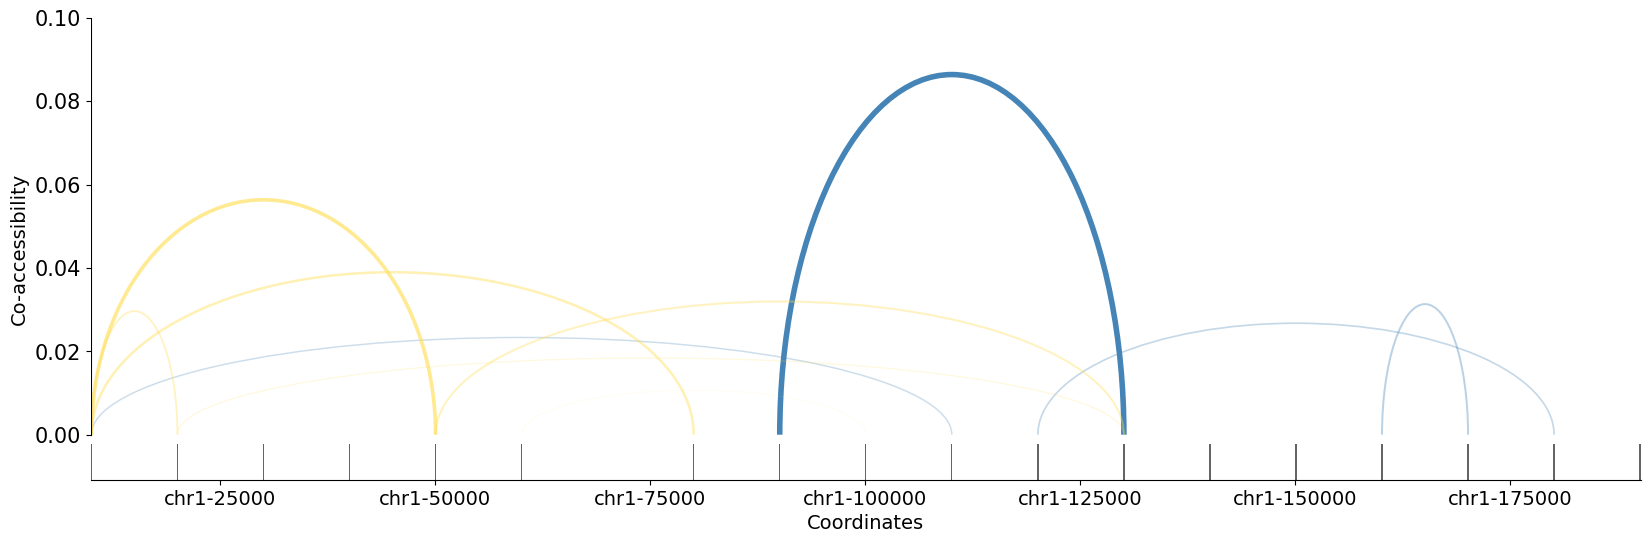

In [39]:
ci.plot_connections(
    circe_network,
    chromosome="chr1",
    start=10_000,
    end=200_000,
    sep=("_","_"),
    abs_threshold=0.01
)

### 6. Find cis-coaccessible connected modules

In addition to pairwise co-accessibility scores, Circe can also be used to <font color=#F98128>**define cis co-accessibility modules**</font> (called CCANs by Cicero), which are modules of sites that are highly co-accessible with one another. We use the Louvain community detection algorithm (Blondel et al., 2008) to find clusters of sites that tended to be co-accessible.<br>
- The function `find_ccans` takes as input a `connection data frame` or the `anndata object` once again, and outputs a data frame with CCAN assignments for each input peak.<br>
- You can also use `add_ccans` to directly add CCAN assignments to your anndata object as `anndata.var['CCAN']`. The regions that aren't assigned to a CCAN will contain `None`.

In [40]:
ccans = ci.find_ccans(circe_network, seed=0)
ccans.head(3)

Coaccessibility cutoff used: 0.02
Number of CCANs generated: 131


,Peak,CCAN
0,chr3_810001_810151,1
1,chr3_1360001_1360151,1
2,chr3_1230001_1230151,1


In [41]:
atac = ci.add_ccans(atac)
atac.var.head(3)

/home/rtrimbou/miniconda3/envs/circe_local/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


Coaccessibility cutoff used: 0.02


,n_cells,chromosome,start,end,CCAN
chr1_1_151,295,chr1,1,151,None
chr1_10001_10151,297,chr1,10001,10151,1
chr1_20001_20151,296,chr1,20001,20151,None


In [42]:
atac.var['CCAN'].value_counts().head(3)

CCAN
17    47
75    34
21    31
Name: count, dtype: int64

With default `coaccess_cutoff_override=None`, the function will determine and report an appropriate co-accessibility score cutoff value for CCAN generation based on the number of overall CCANs at varying cutoffs. You can also set `coaccess_cutoff_override` to be a numeric between 0 and 1, to override the cutoff-finding part of the function. This option is useful if you feel that the cutoff found automatically was too strict or loose, or for speed if you are rerunning the code and know what the cutoff will be, since the cutoff finding procedure can be slow. 

In [43]:
ccans = ci.find_ccans(circe_network, seed=0, coaccess_cutoff_override=1e-7)

Coaccessibility cutoff used: 1e-07
Number of CCANs generated: 41


#### 6.B. Plot only a CCAN module

If you're interested in a specific CCAN module, you can use `circe.draw.plot_ccan` function, precising its CCAN name. Only the connections between <font color=#F98128>**regions belonging to this CCAN module will be plotted**</font>.

This CCAN module is on the chromosome: chr3


/home/rtrimbou/miniconda3/envs/circe_local/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)
/home/rtrimbou/ATACNet/circe/circe/circe.py:337: ImplicitModificationWarning: Setting element `.varp['atac_network']` of view, initializing view as actual.
  adata.varp[key] = adata.varp[key].tocoo()
/home/rtrimbou/ATACNet/circe/circe/draw.py:244: UserWarning: varp parameter is ignored for DataFrame input.
  warnings.warn(


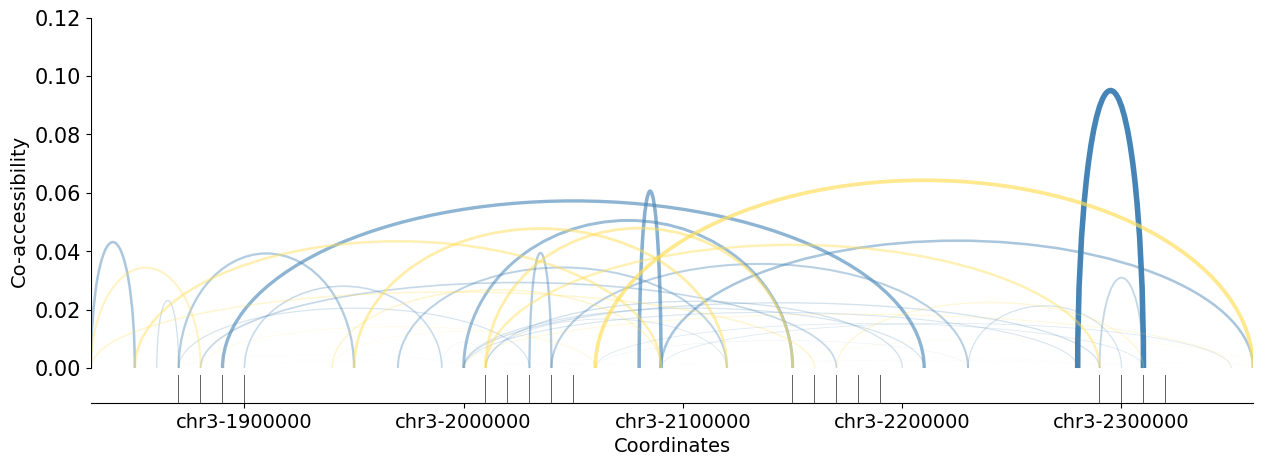

In [47]:
ci.draw.plot_ccan(
    atac,
    ccan_module=atac.var['CCAN'].value_counts().index[1],
    sep=('_', '_'),
    abs_threshold=0,
    figsize=(15,5),
    only_positive=False)

### 7.Coordinates overlap between co-accessible regions and gene bodies

To better understand the role of specific regions and modules, you can additionally plot <font color=#F98128>**gene bodies**</font> falling into your window of interest.
<br> You need first to load gene coordinates as a dataframe, or to download them through `circe.downloads.download_genes`. This functions will require to install the `pybiomart` package Then you can use `ci.draw.plot_connections_genes`, using gene infos and either your AnnData object or the dataframe of Circe's results to compare these locations. 

In [45]:
import circe.downloads
genes_df = ci.downloads.download_genes()

/home/rtrimbou/miniconda3/envs/circe_local/lib/python3.10/site-packages/anndata/_core/storage.py:48: FutureWarning: AnnData previously had undefined behavior around matrices of type <class 'scipy.sparse._coo.coo_matrix'>.In 0.12, passing in this type will throw an error. Please convert to a supported type.Continue using for this minor version at your own risk.
  warnings.warn(msg, FutureWarning)


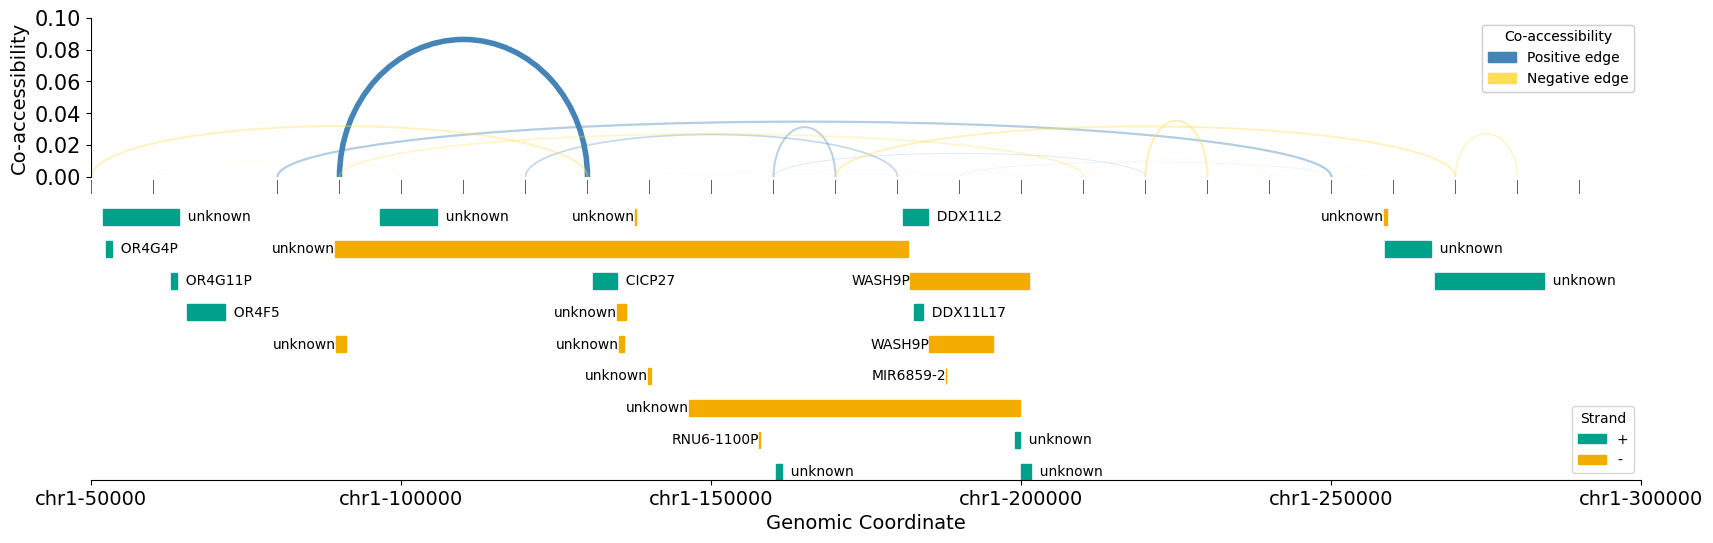

In [50]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize = (20, 6))
ci.draw.plot_connections_genes(
    connections=atac,
    genes=genes_df,
    chromosome="chr1",
    start=50_000,
    end=300_000,
    gene_spacing=30_000,
    y_lim_top=-0.01,
    abs_threshold=0.0,
    track_spacing=0.01,
    track_width=0.01,
    legend=True,
    ax=ax
)

### 7. Work in progress! Happy to get feedbacks :)

If you feel any function could be useful for you on others, don't hesitate to write me at `remi.trimbour@pasteur.fr` or to submit an issue on `github.com/cantinilab/Circe`.